In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("../data/processed/all_features.csv", index_col=0)

In [3]:
df = pd.read_pickle("../data/processed/finbert_probs_only_qa.pkl")

In [4]:
merged_df = pd.merge(df, data, how='left', left_index=True, right_index=True)

In [5]:
merged_df.columns

Index(['positive', 'negative', 'neutral', 'date', 'exchange', 'q', 'ticker',
       'transcript', 'year', 'time', 'change_sp500_1week',
       'change_sp500_1month', 'change_sp500_3month', 'interest_rate',
       'change_interest_rate_3month', 'change_during_news', 'change_day_after',
       'change_week_after', 'change_month_after', 'past_change_1week',
       'past_change_1month', 'past_change_3month', 'processed_transcript'],
      dtype='object')

In [6]:
features_with_sentiment = ['positive','negative','neutral','change_sp500_1week',
       'change_sp500_1month', 'change_sp500_3month', 'interest_rate',
       'change_interest_rate_3month', 'past_change_1week',
       'past_change_1month', 'past_change_3month']

features_without_sentiment = ['change_sp500_1week',
       'change_sp500_1month', 'change_sp500_3month', 'interest_rate',
       'change_interest_rate_3month', 'past_change_1week',
       'past_change_1month', 'past_change_3month']

In [7]:
merged_df.index.name = 'Index'
merged_df = merged_df.sort_values(['date', 'Index'])

In [8]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 3, 4],
}

In [9]:
def correct_direction(y_test, predictions):
    same_sign_count = sum((y_test >= 0) == (predictions >= 0))
    total_samples = len(y_test)
    percentage_same_sign = (same_sign_count / total_samples) * 100
    return percentage_same_sign


def sum_returns_strat(y_test, predictions, buy_threshold=0.00, sell_threshold=-0.00):
    money_for_each_bet = 1
    money = 0
    nb_bets = ((predictions > buy_threshold) | (predictions < sell_threshold)).sum()
    for nb, p in enumerate(predictions):
        if p > buy_threshold:
            money += y_test.iloc[nb] * money_for_each_bet
        if p < sell_threshold:
            money -= min(y_test.iloc[nb] * money_for_each_bet, 1)
    return money / nb_bets if nb_bets > 0 else 0

def prop_sum_returns_strat(y_test, predictions, buy_threshold=0.00, sell_threshold=-0.00):
    
    total_money = len(predictions)
    sum_pred = np.sum(np.abs(predictions))
    nb_bets = ((predictions > buy_threshold) | (predictions < sell_threshold)).sum()
    money = 0
    for nb, p in enumerate(predictions):
        money_for_the_bet = (np.abs(predictions[nb]) / sum_pred) * total_money
        if p > buy_threshold:
            money += y_test.iloc[nb] * money_for_the_bet
        if p < sell_threshold:
            money -= min(y_test.iloc[nb] * money_for_the_bet, money_for_the_bet)
    return  money / nb_bets if nb_bets > 0 else 0

def baseline(y_test):
    money_for_each_bet = 1
    money = 0
    for nb, p in enumerate(y_test):
            money += y_test.iloc[nb] * money_for_each_bet
    return money / len(y_test) if len(y_test) > 0 else 0

### During news with sentiments

In [10]:
X = merged_df[features_with_sentiment]
y = merged_df['change_during_news']

X_train, X_test, y_train, y_test_d_s = train_test_split(X, y, test_size=0.4, shuffle=False)


# Initialize the Random Forest Regressor
rf_model_d_s = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_d_s = GridSearchCV(estimator=rf_model_d_s, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search
grid_search_d_s.fit(X_train, y_train)

# Get the best parameters and best score
best_params_d_s = grid_search_d_s.best_params_
best_score_d_s = grid_search_d_s.best_score_

print("Best Parameters:", best_params_d_s)
print("Best Score (MSE):", -best_score_d_s)

# Use the best parameters to train a new model
best_rf_model_d_s = RandomForestRegressor(**best_params_d_s, random_state=42)
best_rf_model_d_s.fit(X_train, y_train)

# Make predictions on the test set using the best model
best_predictions_d_s = best_rf_model_d_s.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test_d_s, best_predictions_d_s)
print("Best Model Mean Squared Error:", best_mse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.7s
[CV] END max_dep

In [11]:
correct_direction(y_test_d_s, best_predictions_d_s)

52.09669462259497

In [12]:
sum_returns_strat(y_test_d_s, best_predictions_d_s)

0.004439734840874074

In [13]:
prop_sum_returns_strat(y_test_d_s, best_predictions_d_s)

0.006431961194507656

In [14]:
mse = mean_squared_error(y_test_d_s, best_predictions_d_s)
np.sqrt(mse)

0.0795111596663785

In [15]:
np.sqrt(np.mean(y_test_d_s ** 2))

0.07895837274748431

In [16]:
baseline(y_test_d_s)

-0.002841470895442168

                         Feature  Importance
10    Past Asset Returns 3-month    0.148454
9     Past Asset Returns 1-month    0.139802
8      Past Asset Returns 1-week    0.126677
2              Neutral Sentiment    0.106620
1             Negative Sentiment    0.088587
6                  Interest Rate    0.086027
7   Interest Rate Change 3-month    0.070972
3           Returns SP500 1-week    0.066833
5          Returns SP500 3-month    0.060533
0             Positive Sentiment    0.054344
4          Returns SP500 1-month    0.051151


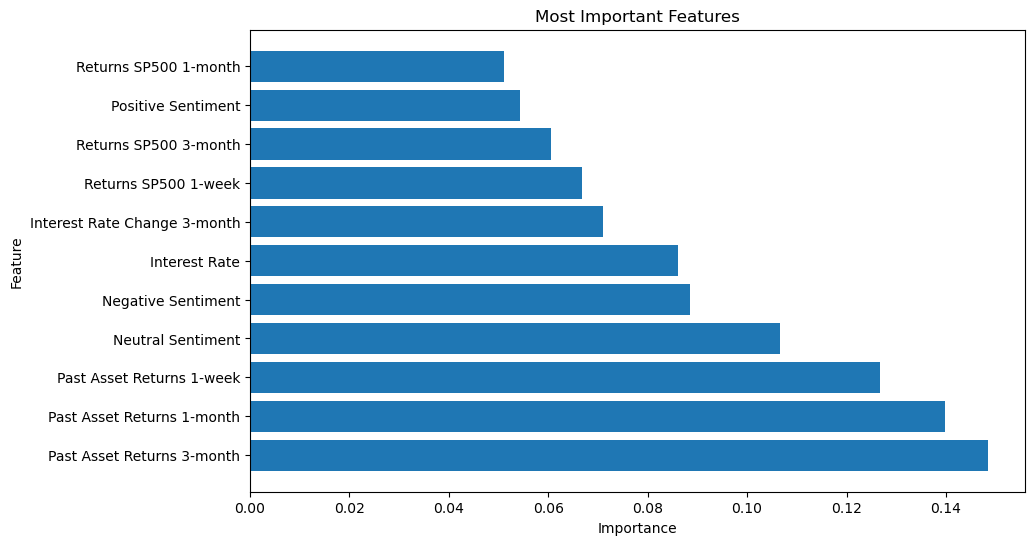

In [17]:
# Assuming 'best_rf_model_d_s' and 'X' are already defined
feature_importances = best_rf_model_d_s.feature_importances_

# Original feature names
original_feature_names = X.columns

# Create a dictionary to map original feature names to new feature names
feature_name_mapping = {
    'past_change_3month': 'Past Asset Returns 3-month',
    'past_change_1month': 'Past Asset Returns 1-month',
    'past_change_1week': 'Past Asset Returns 1-week',
    'neutral': 'Neutral Sentiment',
    'negative': 'Negative Sentiment',
    'interest_rate': 'Interest Rate',
    'change_interest_rate_3month': 'Interest Rate Change 3-month',
    'change_sp500_1week': 'Returns SP500 1-week',
    'change_sp500_3month': 'Returns SP500 3-month',
    'change_sp500_1month': 'Returns SP500 1-month',
    'positive': 'Positive Sentiment',
    # Add more mappings as needed
}

# Create the DataFrame
feature_importance_df = pd.DataFrame({'Feature': original_feature_names, 'Importance': feature_importances})

# Replace original feature names with new names
feature_importance_df['Feature'] = feature_importance_df['Feature'].replace(feature_name_mapping)

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importances with new feature names
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Most Important Features')
plt.show()

In [18]:
best_rf_model_d_s.feature_importances_

array([0.05434364, 0.08858724, 0.1066196 , 0.06683306, 0.05115146,
       0.06053251, 0.08602672, 0.0709723 , 0.12667723, 0.13980213,
       0.14845412])

                        Feature  Importance
10           past_change_3month    0.148454
9            past_change_1month    0.139802
8             past_change_1week    0.126677
2                       neutral    0.106620
1                      negative    0.088587
6                 interest_rate    0.086027
7   change_interest_rate_3month    0.070972
3            change_sp500_1week    0.066833
5           change_sp500_3month    0.060533
0                      positive    0.054344
4           change_sp500_1month    0.051151


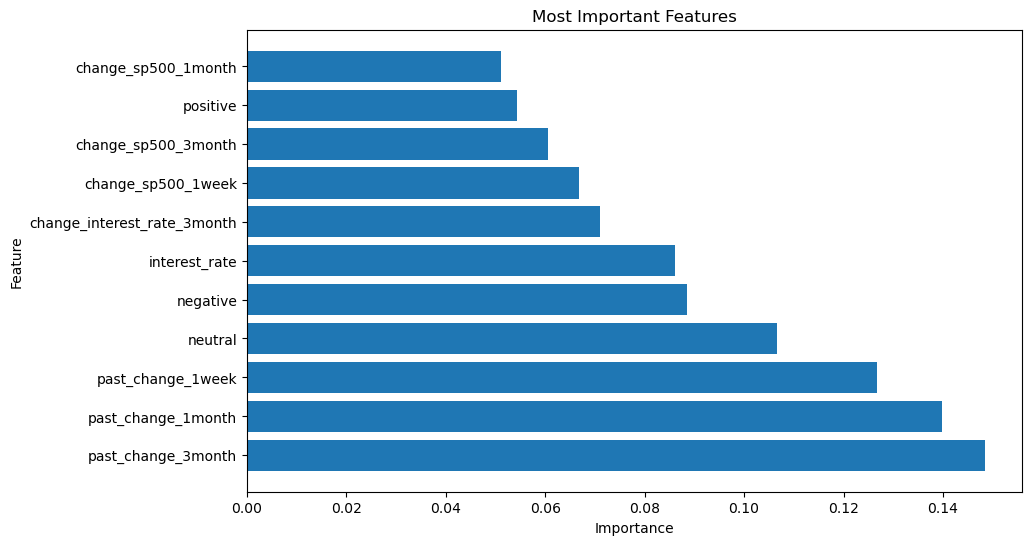

In [19]:
feature_importances = best_rf_model_d_s.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
#print(feature_importance_df)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Most Important Features')
plt.show()

## During news without sentiments

In [20]:
X = merged_df[features_without_sentiment]
y = merged_df['change_during_news']

X_train, X_test, y_train, y_test_d_w = train_test_split(X, y, test_size=0.4, shuffle=False)


# Initialize the Random Forest Regressor
rf_model_d_s = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_d_s = GridSearchCV(estimator=rf_model_d_s, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search
grid_search_d_s.fit(X_train, y_train)

# Get the best parameters and best score
best_params_d_s = grid_search_d_s.best_params_
best_score_d_s = grid_search_d_s.best_score_

print("Best Parameters:", best_params_d_s)
print("Best Score (MSE):", -best_score_d_s)

# Use the best parameters to train a new model
best_rf_model_d_s = RandomForestRegressor(**best_params_d_s, random_state=42)
best_rf_model_d_s.fit(X_train, y_train)

# Make predictions on the test set using the best model
best_predictions_d_w = best_rf_model_d_s.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test_d_w, best_predictions_d_w)
print("Best Model Mean Squared Error:", best_mse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_dep

In [21]:
correct_direction(y_test_d_w, best_predictions_d_w)

50.394671928959056

In [22]:
sum_returns_strat(y_test_d_w, best_predictions_d_w)

0.0017738523822925021

In [23]:
prop_sum_returns_strat(y_test_d_w, best_predictions_d_w)

-0.0007067310149185335

In [24]:
basline = baseline(y_test_d_w)

In [25]:
mse = mean_squared_error(y_test_d_w, best_predictions_d_w)
np.sqrt(mse)

0.0806996027037302

                       Feature  Importance
7           past_change_3month    0.203638
6           past_change_1month    0.189415
5            past_change_1week    0.180196
3                interest_rate    0.104676
4  change_interest_rate_3month    0.086179
2          change_sp500_3month    0.083502
1          change_sp500_1month    0.077748
0           change_sp500_1week    0.074645


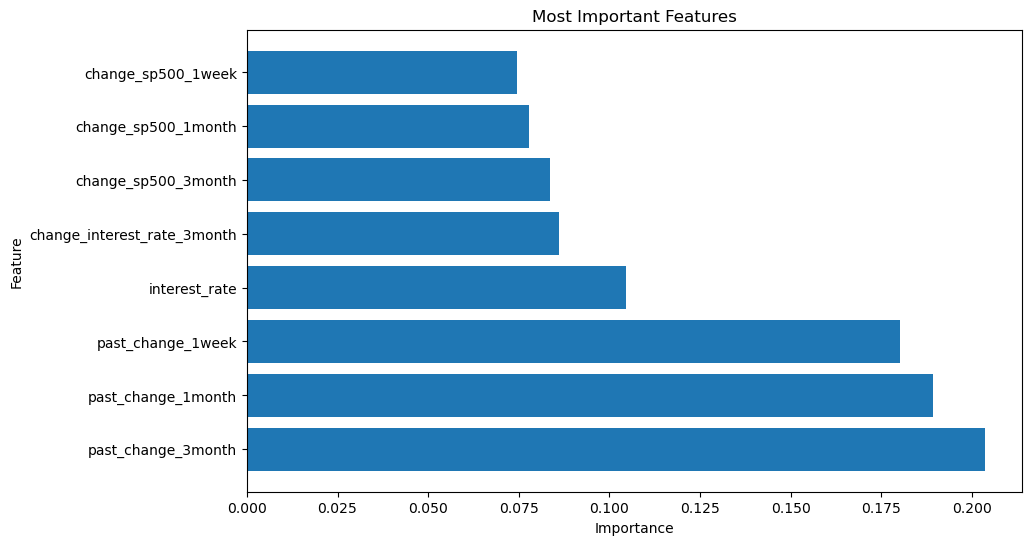

In [26]:
feature_importances = best_rf_model_d_s.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Most Important Features')
plt.show()

## Day after with sentiments

In [27]:
X = merged_df[features_with_sentiment]
y = merged_df['change_day_after']

X_train, X_test, y_train, y_test_dds = train_test_split(X, y, test_size=0.4, shuffle=False)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", -best_score)

# Use the best parameters to train a new model
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
best_predictions_dds = best_rf_model.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test_dds, best_predictions_dds)
print("Best Model Mean Squared Error:", best_mse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END max_dep

In [28]:
correct_direction(y_test_dds, best_predictions_dds)

49.53132708436112

In [29]:
sum_returns_strat(y_test_dds, best_predictions_dds)

0.001563614690442397

In [30]:
prop_sum_returns_strat(y_test_dds, best_predictions_dds)

0.006200390178867168

In [31]:
basline = baseline(y_test_dds)

In [32]:
# Calculate the MSE
mse = mean_squared_error(y_test_dds, best_predictions_dds)
np.sqrt(mse)

0.07200600594680616

                        Feature  Importance
10           past_change_3month    0.211986
9            past_change_1month    0.178045
8             past_change_1week    0.124622
2                       neutral    0.079752
7   change_interest_rate_3month    0.075812
6                 interest_rate    0.062848
0                      positive    0.060453
1                      negative    0.055391
5           change_sp500_3month    0.053704
3            change_sp500_1week    0.048734
4           change_sp500_1month    0.048652


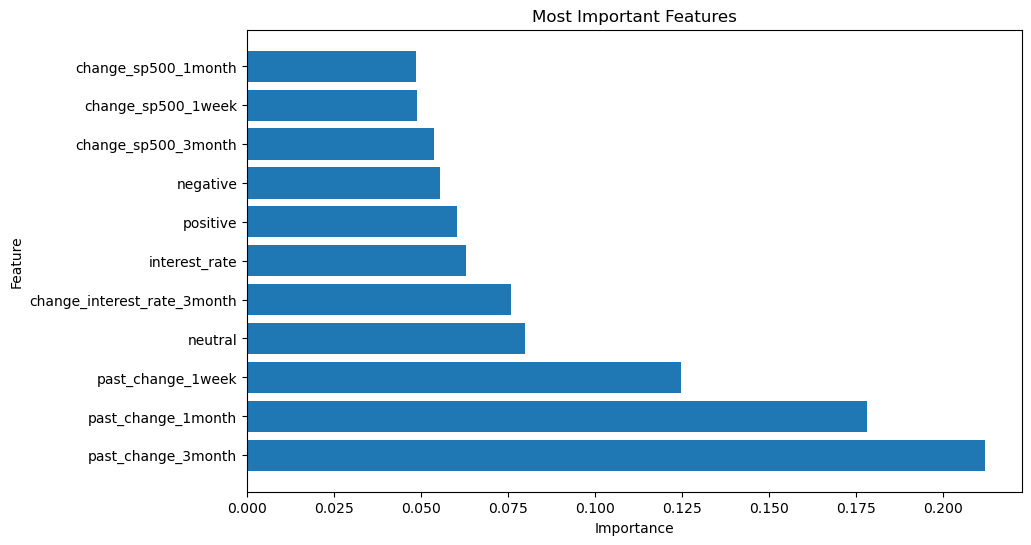

In [33]:
feature_importances = best_rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Most Important Features')
plt.show()

## Day after without sentiments

In [34]:
X = merged_df[features_without_sentiment]
y = merged_df['change_day_after']

X_train, X_test, y_train, y_test_ddw = train_test_split(X, y, test_size=0.4, shuffle=False)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", -best_score)

# Use the best parameters to train a new model
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
best_predictions_ddw = best_rf_model.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test_ddw, best_predictions_ddw)
print("Best Model Mean Squared Error:", best_mse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_dep

In [35]:
correct_direction(y_test_ddw, best_predictions_ddw)

50.888011840157866

In [36]:
sum_returns_strat(y_test_ddw, best_predictions_ddw)

0.00370927500545769

In [37]:
prop_sum_returns_strat(y_test_ddw, best_predictions_ddw)

0.008284066974521156

In [38]:
# Calculate the MSE
mse = mean_squared_error(y_test_ddw, best_predictions_ddw)
np.sqrt(mse)

0.07191960170550747

In [39]:
basline = baseline(y_test_ddw)
basline

0.0019825385649733895

## Week after with sentiments

In [40]:
X = merged_df[features_with_sentiment]
y = merged_df['change_week_after']

X_train, X_test, y_train, y_test_ws = train_test_split(X, y, test_size=0.4, shuffle=False)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", -best_score)

# Use the best parameters to train a new model
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
best_predictions_ws = best_rf_model.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test_ws, best_predictions_ws)
print("Best Model Mean Squared Error:", best_mse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.1s
[CV] END max_dep

In [41]:
correct_direction(y_test_ws, best_predictions_ws)

51.23334977799704

In [42]:
sum_returns_strat(y_test_ws, best_predictions_ws)

0.004321076839251692

In [43]:
prop_sum_returns_strat(y_test_ws, best_predictions_ws)

0.012291332448613279

In [44]:
# Calculate the MSE
mse = mean_squared_error(y_test_ws, best_predictions_ws)
np.sqrt(mse)

0.11494829934895547

In [45]:
basline = baseline(y_test_ws)
basline

0.004382150000065278

                        Feature  Importance
10           past_change_3month    0.181119
9            past_change_1month    0.131592
8             past_change_1week    0.123729
7   change_interest_rate_3month    0.118949
5           change_sp500_3month    0.093896
4           change_sp500_1month    0.090159
2                       neutral    0.062631
6                 interest_rate    0.057407
3            change_sp500_1week    0.050212
0                      positive    0.047664
1                      negative    0.042641


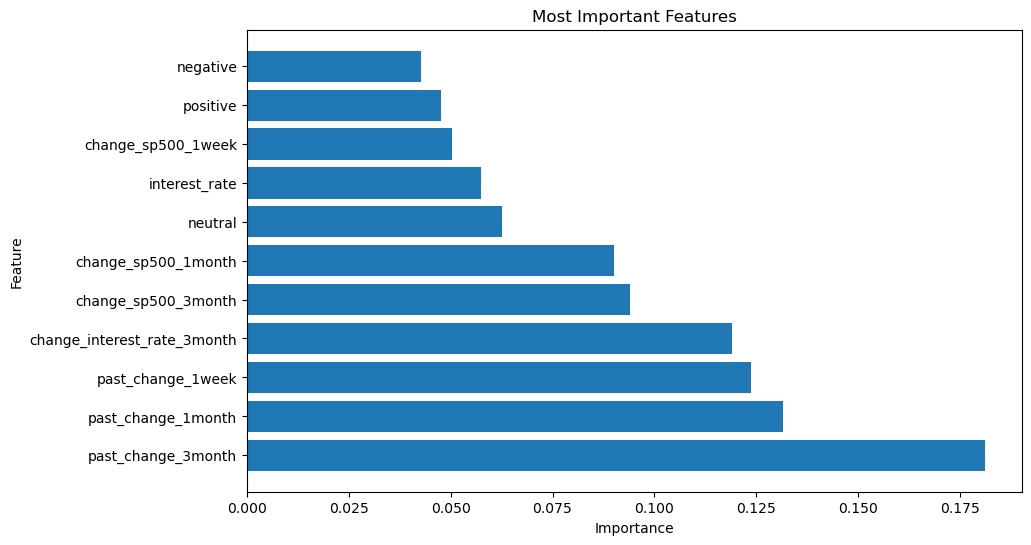

In [46]:
feature_importances = best_rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Most Important Features')
plt.show()

## Week after without sentiments

In [47]:
X = merged_df[features_without_sentiment]
y = merged_df['change_week_after']

X_train, X_test, y_train, y_test_ww = train_test_split(X, y, test_size=0.4, shuffle=False)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", -best_score)

# Use the best parameters to train a new model
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
best_predictions_ww = best_rf_model.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test_ww, best_predictions_ww)
print("Best Model Mean Squared Error:", best_mse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_dep

In [48]:
correct_direction(y_test_ww, best_predictions_ww)

51.55402072027627

In [49]:
sum_returns_strat(y_test_ww, best_predictions_ww)

0.004764171067909198

In [50]:
prop_sum_returns_strat(y_test_ww, best_predictions_ww)

0.0120359537957193

In [51]:
# Calculate the MSE
mse = mean_squared_error(y_test_ww, best_predictions_ww)
np.sqrt(mse)

0.11546744229050702

In [52]:
basline = (y_test_ww * 1).sum() / len(y_test_ww)
basline

0.004382150000065283

## Month after with sentiments

In [53]:
X = merged_df[features_with_sentiment]
y = merged_df['change_month_after']

X_train, X_test, y_train, y_test_ms = train_test_split(X, y, test_size=0.4, shuffle=False)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", -best_score)

# Use the best parameters to train a new model
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
best_predictions_ms = best_rf_model.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test_ms, best_predictions_ms)
print("Best Model Mean Squared Error:", best_mse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   6.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  14.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  18.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.0s
[CV] END max_dep

In [54]:
correct_direction(y_test_ms, best_predictions_ms)

43.48791317217563

In [55]:
sum_returns_strat(y_test_ms, best_predictions_ms)

-0.018596122114396246

In [56]:
prop_sum_returns_strat(y_test_ms, best_predictions_ms)

0.005499794122082412

In [57]:
# Calculate the MSE
mse = mean_squared_error(y_test_ms, best_predictions_ms)
np.sqrt(mse)

0.17051981395329027

In [58]:
basline = (y_test_ms * 1).sum() / len(y_test_ms)
basline

-0.025151170332992905

                        Feature  Importance
10           past_change_3month    0.175866
6                 interest_rate    0.155674
8             past_change_1week    0.152409
5           change_sp500_3month    0.129067
7   change_interest_rate_3month    0.117518
9            past_change_1month    0.064181
3            change_sp500_1week    0.057156
4           change_sp500_1month    0.047339
0                      positive    0.035521
2                       neutral    0.034484
1                      negative    0.030785


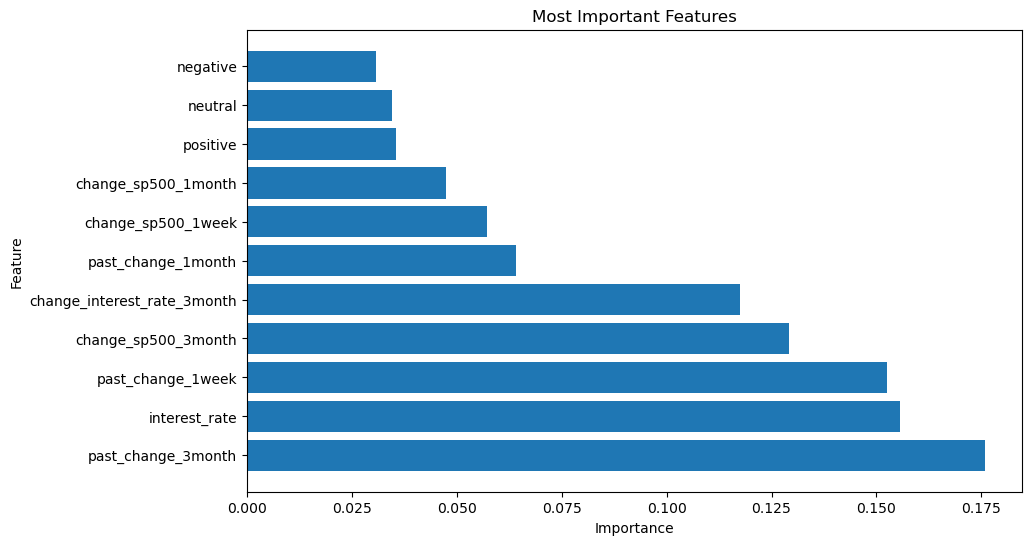

In [59]:
feature_importances = best_rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Most Important Features')
plt.show()

## Month after without sentiments

In [60]:
X = merged_df[features_without_sentiment]
y = merged_df['change_month_after']

X_train, X_test, y_train, y_test_mw = train_test_split(X, y, test_size=0.4, shuffle=False)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", -best_score)

# Use the best parameters to train a new model
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
best_predictions_mw = best_rf_model.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test_mw, best_predictions_mw)
print("Best Model Mean Squared Error:", best_mse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_dep

In [61]:
correct_direction(y_test_mw, best_predictions_mw)

44.178589047853976

In [62]:
sum_returns_strat(y_test_mw, best_predictions_mw)

-0.01752370592873343

In [63]:
prop_sum_returns_strat(y_test_mw, best_predictions_mw)

0.005072188044930558

In [64]:
# Calculate the MSE
mse = mean_squared_error(y_test_mw, best_predictions_mw)
np.sqrt(mse)

0.17108367456292936

In [65]:
basline = (y_test_mw * 1).sum() / len(y_test_mw)
basline

-0.025151170332992905